# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Цель исследования:** обучить модель классифицировать комментарии на позитивные и негативные.

**Задачи исследования:**
- загрузить данные
- выполнить предобработку текста
- преобразовать данные в векторы
- подготовить выборки для обучения
- обучить разные модели
- сделать выводы

## Подготовка

1. Импортируем нужные в работе библиотеки

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.utils import shuffle

import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en

import spacy

2. Откроем данные

In [2]:
data = pd.read_csv(r"C:\Users\Naiana\Desktop\DS projects\ML для текстов\toxic_comments.csv", index_col=0)

3. info

In [3]:
data.info()

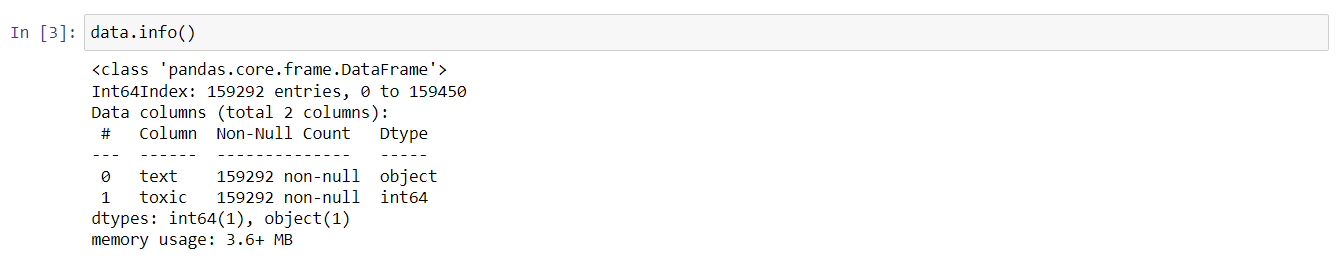

Всего 159292 объекта. Пропуски отсутствуют.

4. head

In [4]:
data.tail()

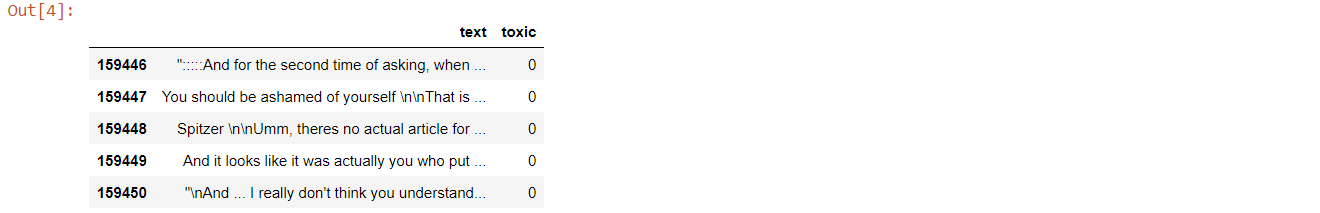

Можно заметить, что последний индекс не соответствует размеру датасета. Обновим индексы.

In [5]:
data = data.reset_index(drop=True)

In [6]:
data.tail()

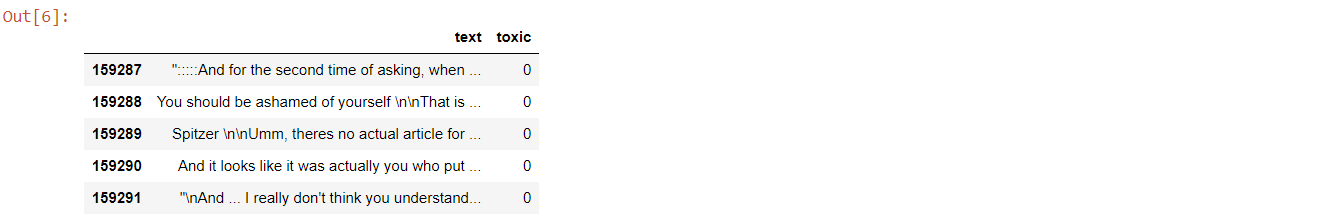

5. Дубликаты

In [7]:
data.duplicated().sum()

6. Классы

In [8]:
display(data.query('toxic == 0').count())
data.query('toxic == 1').count()

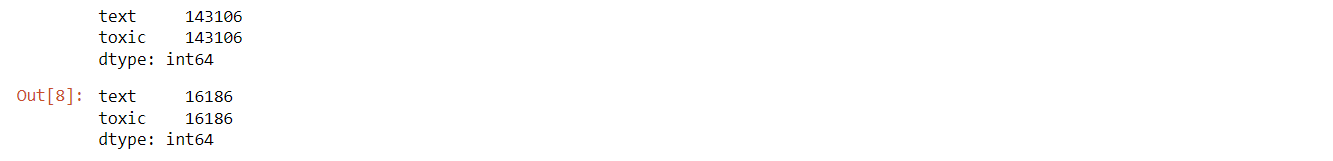

In [9]:
143106 / 16186

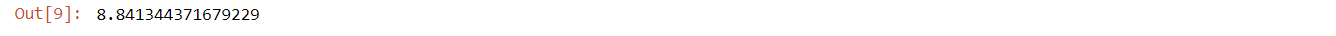

Можно заметить, что объектов с классом 0 в почти девять раз больше, чем объектов с классом 1. Уменьшим количество объектов с классом 0 в восемь раз.

7. Предобработка текста

7.1. удалим ненужные символы

In [15]:
def clean(text):
    no_symbols = re.sub(r'[^a-zA-Z]', ' ', text)
    split = no_symbols.split() 
    return " ".join(split)

In [16]:
%%time

data['text'] = data['text'].apply(clean)

In [17]:
data.shape

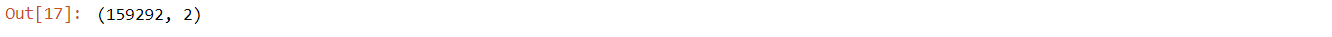

In [18]:
data['text'].tail()

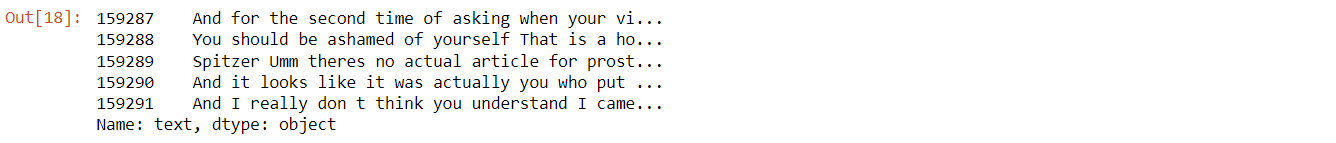

7.2. лемматизируем

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
#%%time

#for i in data['text']:
#    doc = nlp(i)
#    ''.join(token.lemma_ for token in doc)

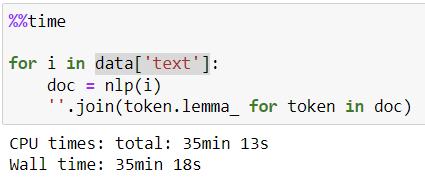

In [22]:
data = pd.read_csv(r"C:\Users\Naiana\Desktop\DS projects\ML для текстов\new_data_0")

In [23]:
data

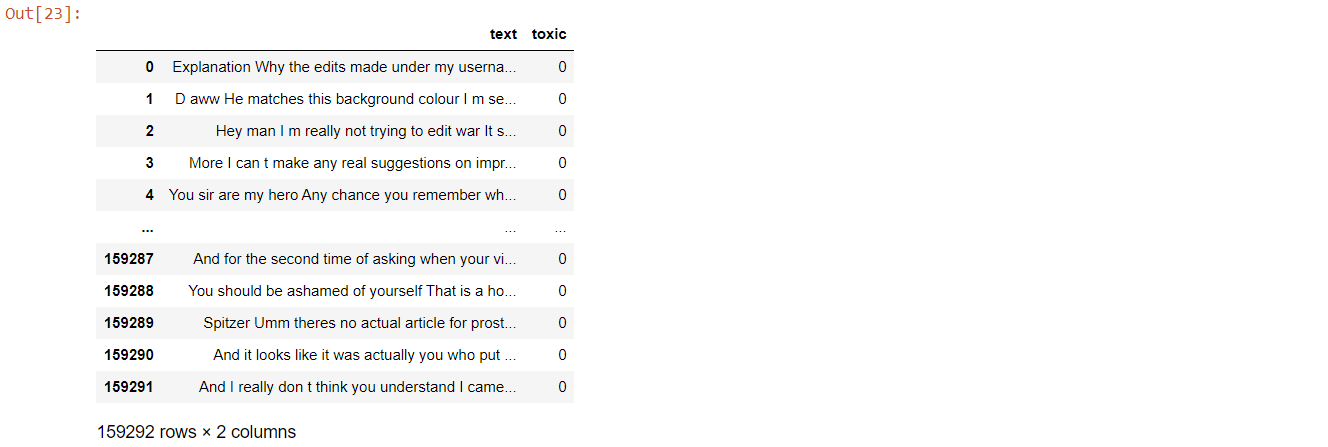

8. Подготовим и разделим данные на выборки

In [26]:
features = data['text']
target = data['toxic']

In [27]:
set(features.index) == set(target.index)

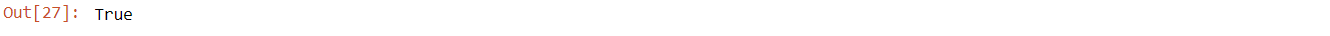

In [28]:
#разделим выборки

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = \
train_test_split(features_train, target_train, test_size=0.25, random_state=12345)

In [29]:
display(features_train.shape)
display(target_train.shape)

display(features_valid.shape)
display(target_valid.shape)

display(features_test.shape)
display(target_test.shape)

In [30]:
#проверим баланс классов

target_train.loc[target_train == 0].shape[0] / target_train.loc[target_train == 1].shape[0]

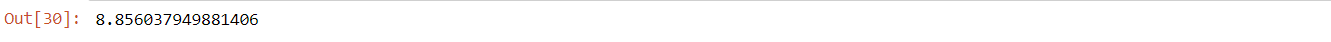

Количество объектов отрицательного класса почти в 9 раз больше количества объектов положительного класса. Учтём это при обучении моделей.

Преобразуем данные в векторы.

In [31]:
features_train = pd.DataFrame(features_train)
features_valid = pd.DataFrame(features_valid)
features_test = pd.DataFrame(features_test)

In [32]:
features_train

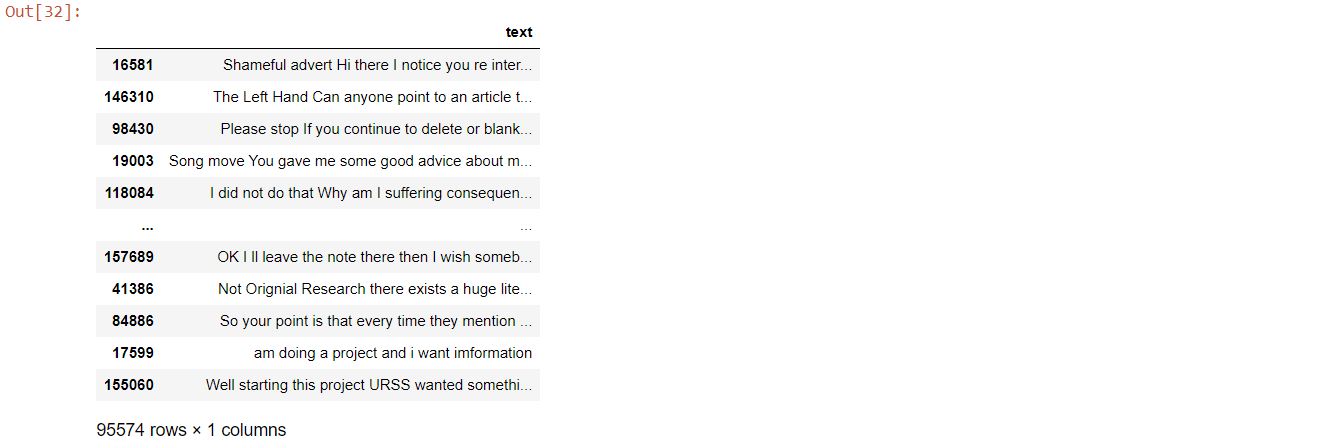

In [33]:
def string(text):
    text = str(text)
    #text = ' '.join(map(str, text))
    return text

In [34]:
features_train['text'] = features_train['text'].apply(string)
features_valid['text'] = features_valid['text'].apply(string)
features_test['text'] = features_test['text'].apply(string)

In [35]:
#загрузим стоп-слова

nltk.download('stopwords')
stopwords = list(set(nltk_stopwords.words('english')))

In [36]:
tf_idf = TfidfVectorizer(stop_words = stopwords)

features_train = tf_idf.fit_transform(features_train['text'])
features_valid = tf_idf.transform(features_valid['text'])
features_test = tf_idf.transform(features_test['text'])

In [37]:
display(features_train.shape)
target_train.shape

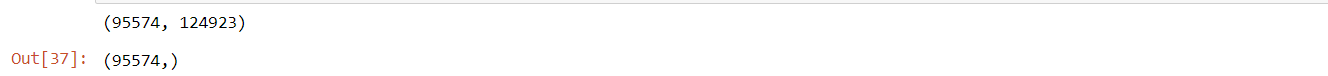

In [40]:
display(features_train.shape)
target_train.shape

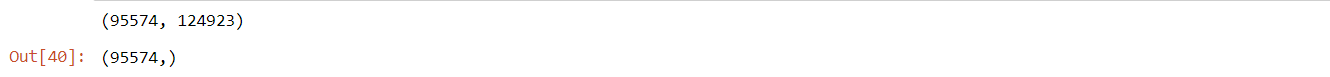

**Вывод.** В этом разделе мы:
- изучили данные
- сбалансировали классы
- лемматизировали тексты
- очистили даннные от ненужных символов и лишних пробелов
- очистили данные от стоп-слов
- подготовили выборки для обучения и тестирования

## Обучение

Рассмотрим модели логистической регрессии, дерева решений, случайного леса и CatBoost.

1. Логистическая регрессия

In [41]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=100, class_weight='balanced', C=10)

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_logreg = f1_score(target_valid, predicted_valid)
print('F1 логистической регрессии:', f1_logreg)

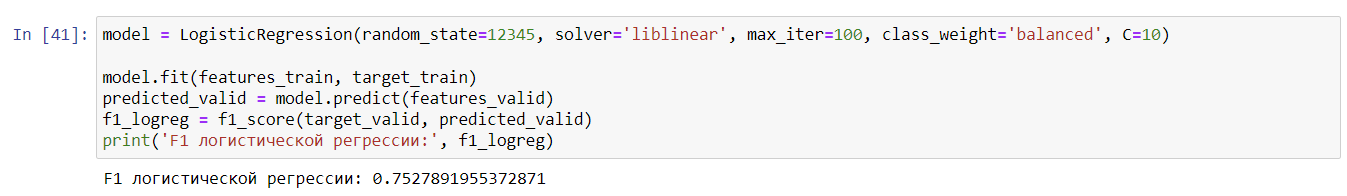

2. Дерево решений

In [42]:
#decision_tree_parameters = {'max_depth': range(1, 15, 1)}
#model = DecisionTreeClassifier(random_state=12345)

#grid = GridSearchCV(model, decision_tree_parameters, cv=5)
#grid.fit(features_train, target_train)
#grid.best_params_

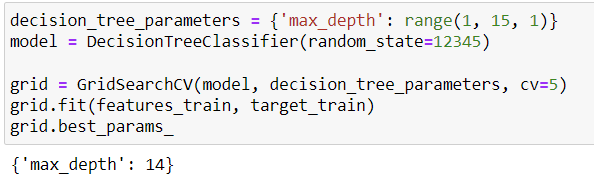

In [43]:
model = DecisionTreeClassifier(max_depth = 14, random_state=12345, class_weight='balanced')

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_tree = f1_score(target_valid, predicted_valid)
print('F1 дерева решений:', f1_tree)

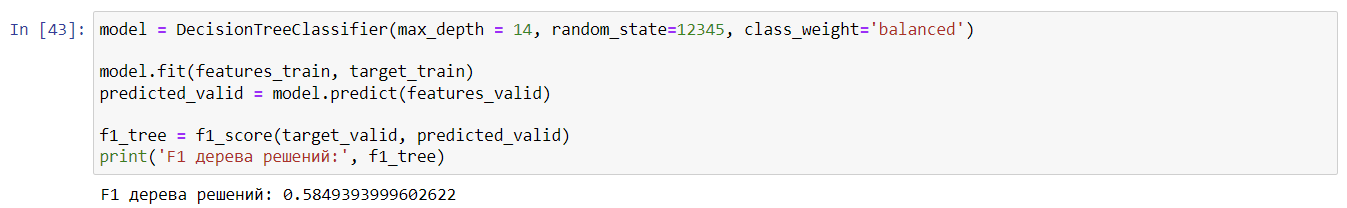

3. Случайный лес

In [44]:
#random_forest_parameters = {'n_estimators': range(10, 101, 10)}
#model = RandomForestClassifier(random_state=12345)

#grid = GridSearchCV(model, random_forest_parameters, cv=3)
#grid.fit(features_train, target_train)
#grid.best_params_

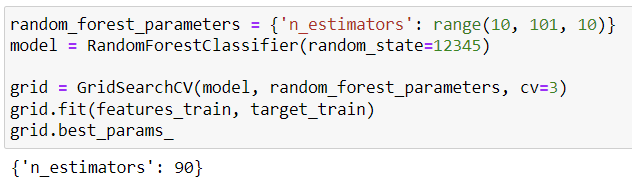

In [45]:
model = RandomForestClassifier(max_depth = 14, n_estimators = 90, random_state=12345, class_weight='balanced')

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_forest = f1_score(target_valid, predicted_valid)
print('F1 случайного леса:', f1_forest)

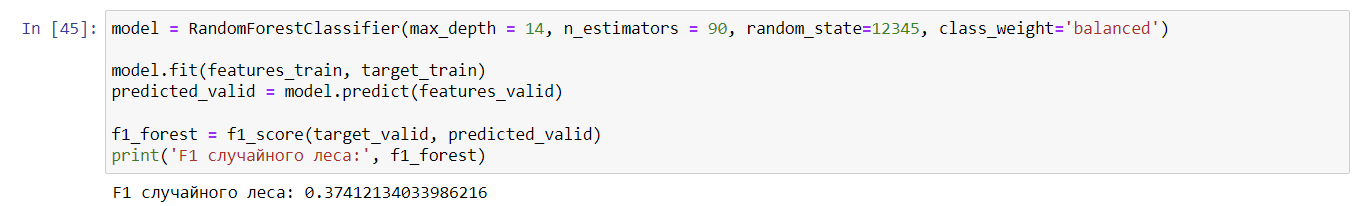

4. LightGBM

Для CatBoost возьмём такие же параметры глубины, как для модели дерева решений.

In [46]:
model = lgb.LGBMClassifier(max_depth=14, n_estimators=90, random_state=12345, class_weight='balanced')

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_lightgbm = f1_score(target_valid, predicted_valid)
print('F1 LightGBM:', f1_lightgbm)

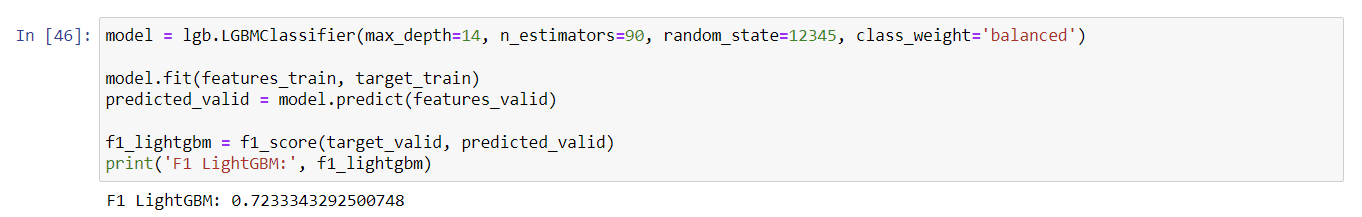

**Лучший результат метрики F1 дала модель логистической регрессии - 0.752.**

5. Протестируем лучшую модель

In [47]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=100, class_weight='balanced')

model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

print('F1 логистической регрессии на тестовой выборке:', f1_score(target_test, predicted_test))

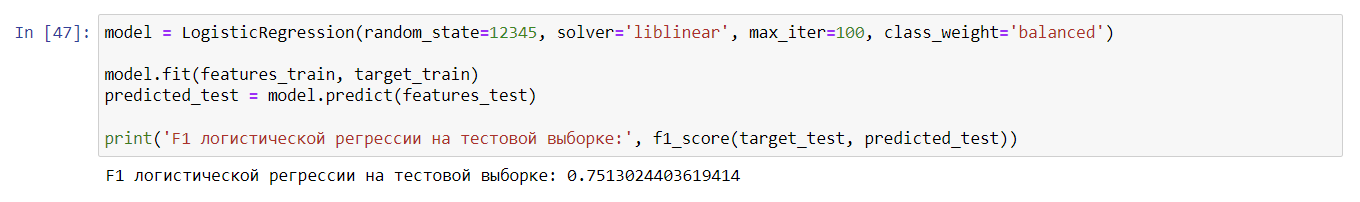

Модель логистической регрессии преодолела порог 0.75 на тестовой выборке.

**Вывод.** В этом разделе мы:
- обучили разные модели
- вычислили и сравнили F1-меры моделей
- определили лучшую модель
- протестировали лучшую модель

## Выводы

**Итог.** В этом проекте мы:
- изучили данные
- сбалансировали классы
- выполнили предобработку текстов
- обучили и сравнили разные модели
- определили лучшую модель
- протестировали лучшую модель

**Вывод.** Мы заметили, что:
- лучший результат дала модель логистической регрессии
- худший результат дала модель случайного леса
- порог F1 = 0.75 преодолела модель логистической регрессии
- порог F1 = 0.75 не преодолели модели дерева решений, случайного леса и LightGBM

- F1 лучшей модели - модели логистической регрессии - на валидационной выборке составило 0.84.
- F1 лучшей модели на тестовой выборке составило 0.82.